<a href="https://colab.research.google.com/github/dardan-gashi01/IN3060-CW/blob/main/HOGMLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

# TODO: Fill in the Google Drive path where you uploaded the lab materials
# Example: GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab Notebooks/Lab materials 01-20210104'

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab Notebooks/CW_Folder_UG/CW_Folder_UG' 
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['.DS_Store', 'CW_Dataset.zip', 'Code', 'Models', 'Personal_Dataset', 'Untitled0.ipynb', 'test_functions.ipynb']


In [3]:
#unzipping the file dataset given to us so we can read from it faster
zip_path = os.path.join(GOOGLE_DRIVE_PATH, 'CW_Dataset.zip')

!cp '{zip_path}' .

!yes|unzip -q CW_Dataset.zip

!rm CW_Dataset.zip

In [4]:
import os, shutil

#function to make the directory if the one we are trying to make does not exist already
def make_dir_if_not_exists(path):
  if not os.path.isdir(path):
    os.mkdir(path)


def dataFolder2(trainImgPath, testImgPath, trainLabelPath, testLabelPath):
  #creating empty folders
  make_dir_if_not_exists('./DataFolder')
  make_dir_if_not_exists('./DataFolder/train')
  make_dir_if_not_exists('./DataFolder/test')
  #making the folders 1-7 to store our data inside them and have emotions as numbers
  for i in range(1,8):
    make_dir_if_not_exists(f'./DataFolder/train/{str(i)}')
    make_dir_if_not_exists(f'./DataFolder/test/{str(i)}')
  #initialisng the train and test paths
  trainPath = './DataFolder/train'
  testPath = './DataFolder/test'


  #reading the text file and splitting it from the space and storing the numbers in a dictionary and assigning it to the images we also read
  file_names = [file for file in os.listdir(trainImgPath) if file.endswith('.jpg')]
  parsed_data = {}
  with open (trainLabelPath, "r") as myfile:
    data = myfile.readlines()
    for line_data in data:
      file_name, number = line_data.strip().split(" ")
      parsed_data[file_name] = number
  
  #loading the images into the correct folders for the train folder
  for file in file_names:
    shutil.copy(f"{trainImgPath}/{file}", f"{trainPath}/{parsed_data[file.replace('_aligned', '')]}/{file}")
    #print("image file: " + file + ' class: ' + parsed_data[file.replace("_aligned", "")])
  #load images into the correct folders

  #repeat the same step as above but this time for the test folder and test.txt
  file_names = [file for file in os.listdir(testImgPath) if file.endswith('.jpg')]
  parsed_data = {}
  with open (testLabelPath, "r") as myfile:
    data = myfile.readlines()
    for line_data in data:
      file_name, number = line_data.strip().split(" ")
      parsed_data[file_name] = number

  for file in file_names:
    shutil.copy(f"{testImgPath}/{file}", f"{testPath}/{parsed_data[file.replace('_aligned', '')]}/{file}")
    #print("image file: " + file + ' class: ' + parsed_data[file.replace("_aligned", "")])
  #load images into the correct folders

In [5]:
#loading the folders
dataFolder2('train', 'test', 'labels/list_label_train.txt', 'labels/list_label_test.txt')

In [6]:
import cv2
from sklearn.model_selection import train_test_split
from skimage import img_as_ubyte, io, color
from sklearn.cluster import MiniBatchKMeans
from sklearn import svm, metrics
from skimage.feature import hog
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from skimage import exposure
from sklearn.neural_network import MLPClassifier

In [7]:
#this is loading the images and labels from our folder into the X and y. This code was taken from the lab 7 tutorial where they loaded the images and labels
def import_selected_data(path, label_list):
    images = []
    labels = []

    if label_list is None:
        folder_names = [folder for folder in sorted(os.listdir(path)) if not folder.startswith('.')]
    else:
        folder_names = [folder for folder in sorted(os.listdir(path)) if folder in label_list]

    for folder in folder_names:
        file_names = [file for file in sorted(os.listdir(os.path.join(path, folder))) if file.endswith('.jpg')]
        for file in file_names:
            images.append(io.imread(os.path.join(path, folder, file)))
            labels.append(folder)

    return images, labels

In [8]:
#loading the images into X, y 
X, y = import_selected_data('DataFolder/train', label_list=['1', '2', '3','4','5','6','7'])

In [9]:
#here we had to reshape our data so that we could oversample with SMOTE
X_array = np.array(X)
Y_array = np.array(y)
X_array = X_array.reshape(len(y),100*100*3)

In [10]:
#imported the libraries needed to oversample with imblearn
#I used the link given to us in lab 7 to understand this : https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/
#from the link I saw smote and tried it our and I preferred it more as it was easier to use and gave me better results
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTEENN
from imblearn.pipeline import make_pipeline
from collections import Counter
oversample = SMOTE()
X_R, y_R = oversample.fit_resample(X_array, y)

In [11]:
#then I reshaped back to normal after oversampling
X = X_R.reshape(len(y_R), 100, 100, 3)
y = y_R

In [12]:
#then I split the data into train and test using the train_test_split funciton from sklearn
X_train, X_test, y_train, y_test = train_test_split(
    X, y , test_size=0.2, shuffle=True, stratify=y)

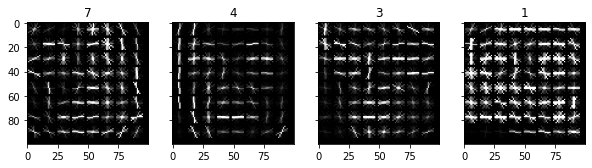

In [13]:
#I then applied hog to my images 
#this block of code is inspired from the SIFT feature extractor in lab 7 but its adapted to using hog feature extractors
hog_list = []
hog_features=[]
labels_list = []

fig, ax = plt.subplots(1, 4, figsize=(10, 8), sharex=True, sharey=True)
#iterating all of the train images to apply hog feature extractor to them
for i in range(len(X_train)):
  img = img_as_ubyte(color.rgb2gray(X_train[i]))
  #for this I got this from doing the hog exercise in lab 6 and used https://www.analyticsvidhya.com/blog/2019/09/feature-engineering-images-introduction-hog-feature-descriptor/ to help me understand it and get an example
  #storing the features and the hog image when running the function on the grayscale image
  fd, hog_image = hog(img, orientations=8, pixels_per_cell=(12, 12), cells_per_block=(1, 1), visualize=True)
  #displaying how the hog images look
  if i < 4:
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

    ax[i].imshow(hog_image_rescaled, cmap=plt.cm.gray)
    ax[i].set_title(y_train[i])
  #adding the infromation we extracted to our lists we defined before the loop
  hog_list.append(hog_image)
  labels_list.append(y_train[i])
  hog_features.append(fd)
 
fig.tight_layout
plt.show()

In [25]:
#creating the classifier for the multi layer perceptron 
#this was adapted from lab 7 and also adapted from https://scikit-learn.org/stable/auto_examples/neural_networks/plot_mnist_filters.html
classifier = MLPClassifier(hidden_layer_sizes=(100,),activation='relu', max_iter=100, alpha=1e-4,
                    solver='sgd', verbose=True, random_state=1,
                    learning_rate_init=.0001, shuffle=True)

In [15]:
classifier = MLPClassifier(max_iter = 100)

In [26]:
#converting to np array
hog_array = np.vstack(hog_list)

In [27]:
#reshaping it so we can fit our model as we need a <=2d array but we currently had a 3d array
hog_array = hog_array.reshape(len(labels_list), 100*100)

trying to add GridSearch to find the most optimized hyperparameters but it kept crashing

In [ ]:
'''
from sklearn.model_selection import GridSearchCV
params = {
    'hidden_layer_sizes': [(10,30,7),(50,)],
    'activation': ['relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001],
    'learning_rate': ['constant','adaptive'], 
    }
grid_MLP = GridSearchCV(classifier, params, n_jobs=-1, cv=1)
grid_MLP.fit(hog_array, labels_list)
'''

In [28]:
#fitting the model for 100 iterations
classifier.fit(hog_array, labels_list)

Iteration 1, loss = 1.96494915
Iteration 2, loss = 1.31562837
Iteration 3, loss = 1.18287583
Iteration 4, loss = 1.10663574
Iteration 5, loss = 1.05147705
Iteration 6, loss = 1.01417875
Iteration 7, loss = 0.97772169
Iteration 8, loss = 0.95001033
Iteration 9, loss = 0.92482064
Iteration 10, loss = 0.90390688
Iteration 11, loss = 0.88111309
Iteration 12, loss = 0.86444842
Iteration 13, loss = 0.84769986
Iteration 14, loss = 0.83255455
Iteration 15, loss = 0.81764264
Iteration 16, loss = 0.80562906
Iteration 17, loss = 0.79109380
Iteration 18, loss = 0.77926558
Iteration 19, loss = 0.76735435
Iteration 20, loss = 0.75720841
Iteration 21, loss = 0.74459500
Iteration 22, loss = 0.73609703
Iteration 23, loss = 0.72308169
Iteration 24, loss = 0.71650819
Iteration 25, loss = 0.70579721
Iteration 26, loss = 0.69644960
Iteration 27, loss = 0.68926479
Iteration 28, loss = 0.68166640
Iteration 29, loss = 0.67396720
Iteration 30, loss = 0.66429284
Iteration 31, loss = 0.65682589
Iteration 32, los

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


MLPClassifier(learning_rate_init=0.0001, max_iter=100, random_state=1,
              solver='sgd', verbose=True)

In [29]:
#the same thing gets repeated as for the train images but this time for the test images in the same way
hog_list_test = []
hog_features_test=[]
labels_list_test = []

for i in range(len(X_test)):
  img = img_as_ubyte(color.rgb2gray(X_test[i]))
  fd, hog_image = hog(img, orientations=8, pixels_per_cell=(12, 12), cells_per_block=(1, 1), visualize=True)

  hog_list_test.append(hog_image)
  labels_list_test.append(y_test[i])
  hog_features_test.append(fd)

In [30]:
hog_array_test = np.vstack(hog_list_test)

In [31]:
hog_array_test = hog_array_test.reshape(len(labels_list_test), 100*100)

In [32]:
y_pred = classifier.predict(hog_array_test)

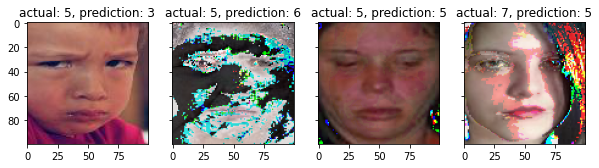

In [33]:
#I then plot the 4 images to see if they work and how they display
fig, ax = plt.subplots(1, 4, figsize=(10, 8), sharex=True, sharey=True)

for i in range(4):
  ax[i].imshow(X_test[i], cmap=plt.cm.gray)
  ax[i].set_title(f'actual: {y_test[i]}, prediction: {y_pred[i]}')

In [34]:
#here I print the report for the model prediction and I got this from the lab7 tutorial where they used it for the SIFT + SVM model
from sklearn.metrics import classification_report,accuracy_score
print("Accuracy for HOGMLP is: "+str(accuracy_score(y_test, y_pred)))
print('\n')
print(classification_report(y_test, y_pred))

Accuracy for HOGMLP is: 0.7310282891782667


              precision    recall  f1-score   support

           1       0.74      0.77      0.75       954
           2       0.82      0.86      0.84       955
           3       0.67      0.69      0.68       954
           4       0.81      0.80      0.81       955
           5       0.64      0.58      0.61       954
           6       0.85      0.75      0.79       954
           7       0.60      0.65      0.62       955

    accuracy                           0.73      6681
   macro avg       0.73      0.73      0.73      6681
weighted avg       0.73      0.73      0.73      6681



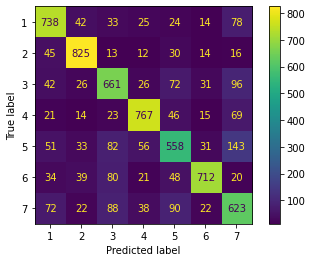

In [35]:
#I then plotted a confusion matrix to get a nice and this aswell was taken from lab 7 task 1.3 where I did the research and found https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html
#I also knew how to do this from my intro to AI module in term 1 where we had to use this many times
metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

In [ ]:
#I then saved my model using joblib and used this to assist me : https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/
from joblib import dump, load
dump(classifier, os.path.join(GOOGLE_DRIVE_PATH, 'Models/HOGMLP.joblib')) 

['drive/My Drive/Colab Notebooks/CW_Folder_UG/CW_Folder_UG/Models/HOGMLP.joblib']